### Imports

In [38]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import math

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Reshape, Lambda, ZeroPadding2D, GaussianNoise, AlphaDropout
from keras.layers.core import Flatten, Dropout
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical, normalize

from sklearn.model_selection import train_test_split
import tensorflow as tf

np.random.seed(3554)
cwd = os.getcwd()
#for windows
model_path = cwd + '\\models\\'

Manually create tensorflow session to avoid potential OEM errors on laptop's GPU.

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)
K.set_image_dim_ordering('tf')

### Load Data

In [3]:
data = pd.read_json("Data/train/train.json")
data.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 62.7+ KB


### Missing values

In [5]:
data[data.loc[:,'inc_angle'] == "na"].count()

band_1        133
band_2        133
id            133
inc_angle     133
is_iceberg    133
dtype: int64

In [6]:
data[data.loc[:,'inc_angle'] == "na"].loc[:,'inc_angle'] = 45

D:\Anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [7]:
train_df = data
train_df['inc_angle'][train_df['inc_angle'] == 'na'] = 45


D:\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [8]:
train_df['inc_angle'][train_df['inc_angle'] == 45].count()

133

### Transform for NN

In [9]:
X_train = np.array(train_df['band_1'].tolist()).reshape(-1,75,75)
X_train.shape

(1604, 75, 75)

In [10]:
#merge bands and create 3rd channel
band_1 = normalize(np.array(train_df['band_1'].tolist()).reshape(-1,75,75), axis=1)
band_2 = normalize(np.array(train_df['band_2'].tolist()).reshape(-1,75,75), axis=1)
band_3 = (band_1 + band_2)/2
band_4 = normalize((band_1 * band_2))
X = np.stack((band_1,band_2,band_3,band_4),axis=3)
X.shape

(1604, 75, 75, 4)

In [11]:
band_3.max()

0.19009767909967581

In [12]:
# pre-processing: divide by max and substract mean

#scale = np.max(X_train)
#X_train /= scale

#mean = np.mean(X_train)
#X_train -= mean

In [13]:
75*75

5625

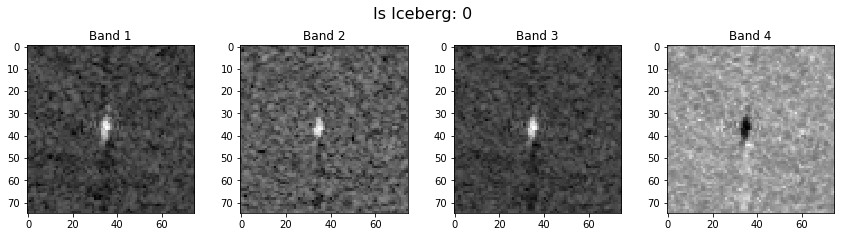

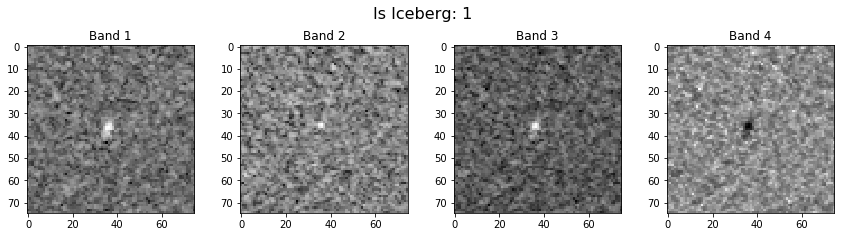

In [14]:
def plot_bands(index, cmap="gray"):
    fig = plt.figure(figsize=(12,6))
    fig.suptitle("Is Iceberg: %x" % (train_df.loc[index,'is_iceberg']), fontsize=16)
    ax1 = fig.add_subplot(241)
    ax1.set_title("Band 1")
    ax1.imshow(band_1[index], cmap=cmap)
    ax2 = fig.add_subplot(242)
    ax2.set_title("Band 2")
    ax2.imshow(band_2[index], cmap=cmap)
    ax3 = fig.add_subplot(243)
    ax3.set_title("Band 3")
    ax3.imshow(band_3[index], cmap=cmap)
    ax3 = fig.add_subplot(244)
    ax3.set_title("Band 4")
    ax3.imshow(band_4[index], cmap=cmap)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_bands(0,cmap="gray")
plot_bands(2,cmap="gray")


In [15]:
y = to_categorical(train_df.loc[:,'is_iceberg'], num_classes=2)

### Split into train test and validation sets

In [16]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_val.shape)

(1283, 75, 75, 4)
(321, 75, 75, 4)


### Data augmentation

In [17]:
X_train_sample = X_train[:]
y_train_sample = y_train[:]
print(X_train_sample.shape)

datagen = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=180,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

#datagen_val = ImageDataGenerator(
#   samplewise_center=False,
#   samplewise_std_normalization=False,
#   rotation_range=0.1,
#   width_shift_range=0.01,
#   height_shift_range=0.01,
#   shear_range=0.01,
#   zoom_range=0.01,
#   fill_mode='nearest')

    #zca_whitening=True,
    #zca_epsilon=1e-6,
    #rotation_range=0.,
    #width_shift_range=0.,
    #height_shift_range=0.,
    #shear_range=0.,
    #zoom_range=0.,
    #channel_shift_range=0.,
    #fill_mode='nearest',
    #cval=0.,
    #horizontal_flip=False,
    #vertical_flip=False,
    #rescale=None,
    
datagen.fit(X_train_sample)
#datagen_val.fit(X_val)

(1283, 75, 75, 4)


### Keras model

In [24]:
model_code="CNN_2017_12_15_v1"

In [18]:
model = Sequential([
    #conv-block
    GaussianNoise(0.005, input_shape=(75, 75, 4) ),
    #Conv2D(64, (3,3), input_shape=(75, 75, 3), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    BatchNormalization(),
    AlphaDropout(0.2),
    
    #conv-block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Dropout(0.2),
    
    #conv-block
    ZeroPadding2D(),
    Conv2D(256, (3, 3), activation='relu'),
    #BatchNormalization(axis=1),
    MaxPooling2D((2, 2), strides=(2, 2)),
    BatchNormalization(),
    Dropout(0.2),

    #flatten
    Flatten(),

    #dense-block
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    #dense-block
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
loss='categorical_crossentropy',
metrics=['accuracy'])

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.66
    patience = 7.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
    if math.fmod(epoch, patience) == 0:
        print("Setting learning rate: ",lrate)
    return lrate

def get_callbacks(filepath, patience=10):
    #es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    #reduceLr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
    #                          patience=5, min_lr=0.000001, verbose=1)
    lrScheduler = LearningRateScheduler(step_decay)
    return [msave, lrScheduler]

file_path = model_path + model_code + ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=10)

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_1 (GaussianNo (None, 75, 75, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 73, 64)        2368      
_________________________________________________________________
batch_normalization_1 (Batch (None, 73, 73, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 35, 35, 128)       512       
__________

In [20]:
start_time = time.monotonic()

H = model.fit_generator(datagen.flow(X_train_sample, y_train_sample, batch_size=32),
                    steps_per_epoch=len(X_train_sample)/32,
                    #validation_data=datagen.flow(X_val, y_val, batch_size=32), validation_steps=len(X_val)/32,
                    validation_data=[X_val,y_val],
                    epochs=100, callbacks=callbacks)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

Setting learning rate:  0.001
Epoch 1/100
41/40 [==============================] - 25s - loss: 0.8455 - acc: 0.6317 - val_loss: 1.7963 - val_acc: 0.5109
Epoch 2/100
41/40 [==============================] - 22s - loss: 0.5354 - acc: 0.7358 - val_loss: 0.8248 - val_acc: 0.5109
Epoch 3/100
41/40 [==============================] - 22s - loss: 0.5262 - acc: 0.7343 - val_loss: 4.0151 - val_acc: 0.5109
Epoch 4/100
41/40 [==============================] - 22s - loss: 0.4909 - acc: 0.7652 - val_loss: 2.8901 - val_acc: 0.5109
Epoch 5/100
41/40 [==============================] - 22s - loss: 0.4115 - acc: 0.8109 - val_loss: 3.1078 - val_acc: 0.5109
Epoch 6/100
41/40 [==============================] - 22s - loss: 0.3700 - acc: 0.8284 - val_loss: 3.5327 - val_acc: 0.5109
Epoch 7/100
41/40 [==============================] - 22s - loss: 0.4001 - acc: 0.8212 - val_loss: 0.9705 - val_acc: 0.4891
Setting learning rate:  0.00066
Epoch 8/100
41/40 [==============================] - 22s - loss: 0.4265 - acc

41/40 [==============================] - 22s - loss: 0.2534 - acc: 0.8940 - val_loss: 0.6774 - val_acc: 0.7695
Epoch 65/100
41/40 [==============================] - 22s - loss: 0.3384 - acc: 0.8644 - val_loss: 0.7054 - val_acc: 0.7664
Epoch 66/100
41/40 [==============================] - 22s - loss: 0.2770 - acc: 0.8784 - val_loss: 0.7183 - val_acc: 0.7695
Epoch 67/100
41/40 [==============================] - 22s - loss: 0.3199 - acc: 0.8750 - val_loss: 0.7262 - val_acc: 0.7664
Epoch 68/100
41/40 [==============================] - 22s - loss: 0.2668 - acc: 0.8799 - val_loss: 0.8102 - val_acc: 0.7508
Epoch 69/100
41/40 [==============================] - 22s - loss: 0.2621 - acc: 0.8879 - val_loss: 0.6579 - val_acc: 0.7757
Epoch 70/100
41/40 [==============================] - 22s - loss: 0.2661 - acc: 0.8841 - val_loss: 0.6983 - val_acc: 0.7632
Setting learning rate:  1.5683368809107964e-05
Epoch 71/100
41/40 [==============================] - 22s - loss: 0.2659 - acc: 0.8894 - val_loss:

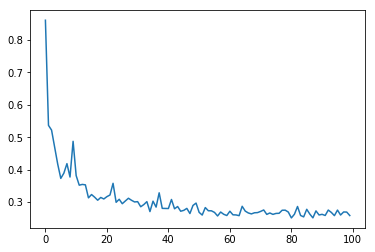

In [21]:
plt.plot(H.history['loss'])
plt.show()

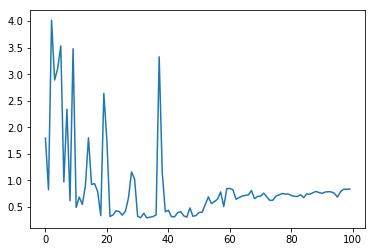

In [22]:
plt.plot(H.history['val_loss'])
plt.show()

In [39]:
model.save_weights(model_path + model_code +'.model.pkl')